# EuroSAT_MS – Pretrained Deep Learning Pipeline

This notebook fine-tunes the Hugging Face `Rhodham96/EuroSatCNN` multispectral classifier on the 13-channel EuroSAT dataset and prepares a Kaggle submission using the resulting deep learning model.

## 1) Environment Setup

In [28]:
!pip install -q rasterio transformers huggingface_hub accelerate

## 2) Imports & Utilities

In [29]:
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except ImportError:
    drive = None  # type: ignore
    IN_COLAB = False
from pathlib import Path
import os, random, math, time, shutil, glob, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from collections import Counter
from functools import lru_cache
from huggingface_hub import hf_hub_download
import importlib.util
from types import SimpleNamespace
from datetime import datetime
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import get_cosine_schedule_with_warmup
from tqdm.auto import tqdm

import rasterio


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


RANDOM_SEED = 42
set_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


## 3) Mount Drive and Extract EuroSAT_MS

In [30]:
if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    DRIVE_ROOT = Path('/content/drive/MyDrive/ML_HSG')
    if not DRIVE_ROOT.exists():
        raise FileNotFoundError('Google Drive directory /content/drive/MyDrive/ML_HSG not found. Upload data archives before proceeding.')

    KAGGLE_ZIP = DRIVE_ROOT / 'kaggle_data.zip'
    EUROSAT_ZIP = DRIVE_ROOT / 'EuroSAT_MS.zip'
    LOCAL_KAGGLE_ROOT = Path('/content/drive/MyDrive/ML_HSG/kaggle_data')
    LOCAL_EUROSAT_ROOT = Path('/content/drive/MyDrive/ML_HSG/EuroSAT_MS')

    def ensure_local_extraction(zip_path: Path, expected_dir: Path) -> None:
        if not zip_path.exists():
            raise FileNotFoundError(f'Required archive missing on Drive: {zip_path}')
        if expected_dir.exists():
            print(f'{expected_dir} already extracted.')
            return
        print(f'Extracting {zip_path.name} -> {expected_dir.parent}')
        shutil.unpack_archive(str(zip_path), str(expected_dir.parent))
        if not expected_dir.exists():
            # fallback: some archives create an extra level; try stem
            candidate = expected_dir.parent / zip_path.stem
            if candidate.exists():
                expected_dir.mkdir(parents=True, exist_ok=True)
                for item in candidate.iterdir():
                    target = expected_dir / item.name
                    if target.exists():
                        continue
                    if item.is_dir():
                        shutil.copytree(item, target)
                    else:
                        shutil.copy2(item, target)
            if not expected_dir.exists():
                raise FileNotFoundError(f'Extraction of {zip_path.name} did not create {expected_dir}')
        print(f'Extraction complete: {expected_dir}')

    ensure_local_extraction(KAGGLE_ZIP, LOCAL_KAGGLE_ROOT)
    ensure_local_extraction(EUROSAT_ZIP, LOCAL_EUROSAT_ROOT)

    BASE_DIR = Path('/content')
    KAGGLE_ROOT = LOCAL_KAGGLE_ROOT
    eurosat_candidate = LOCAL_EUROSAT_ROOT / 'EuroSAT_MS'
    EUROSAT_TILES_DIR = eurosat_candidate if eurosat_candidate.exists() else LOCAL_EUROSAT_ROOT
    MODELS_DIR = DRIVE_ROOT / 'models'
else:
    BASE_DIR = Path(os.environ.get('EUROSAT_BASE_DIR', Path.cwd() / 'ML_HSG'))
    KAGGLE_ROOT = BASE_DIR / 'kaggle_data'
    EUROSAT_TILES_DIR = BASE_DIR / 'EuroSAT_MS' / 'EuroSAT_MS'
    MODELS_DIR = BASE_DIR / 'models'

print(f'Using data base directory: {BASE_DIR}')

TRAIN_CSV_PATH = KAGGLE_ROOT / 'train.csv'
TEST_CSV_PATH = KAGGLE_ROOT / 'test.csv'

if not TRAIN_CSV_PATH.exists():
    raise FileNotFoundError(f'train.csv not found at {TRAIN_CSV_PATH}')

if not TEST_CSV_PATH.exists():
    print('test.csv not found; Kaggle submission generation will be skipped.')
    TEST_CSV_PATH = None

DATASET_ROOT = KAGGLE_ROOT
EXTRACT_ROOT = KAGGLE_ROOT

print(f'DATASET_ROOT set to {DATASET_ROOT}')
print(f'EuroSAT tiles located in {EUROSAT_TILES_DIR}')


Mounted at /content/drive
/content/drive/MyDrive/ML_HSG/kaggle_data already extracted.
/content/drive/MyDrive/ML_HSG/EuroSAT_MS already extracted.
Using data base directory: /content
DATASET_ROOT set to /content/drive/MyDrive/ML_HSG/kaggle_data
EuroSAT tiles located in /content/drive/MyDrive/ML_HSG/EuroSAT_MS/EuroSAT_MS


## 4) Collect Samples and Visualise

In [31]:
CLASS_NAMES = []
samples = []

train_csv_path = TRAIN_CSV_PATH
if not train_csv_path.exists():
    raise FileNotFoundError(f'train.csv not found at {train_csv_path}')

print(f'Using Kaggle train.csv at {train_csv_path}')
print('Kaggle test set will be loaded later from kaggle_data/testset/testset/*.npy for submission generation.')

kaggle_train_df = pd.read_csv(train_csv_path)
CLASS_NAMES = sorted(kaggle_train_df['label'].astype(str).unique())
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}
print(f'Detected {len(CLASS_NAMES)} classes from Kaggle metadata -> {CLASS_NAMES}')

relative_paths = [Path(str(p).strip()) for p in kaggle_train_df['path']]
if not relative_paths:
    raise ValueError('train.csv does not contain any paths.')

DATA_ROOT = EUROSAT_TILES_DIR
if not DATA_ROOT.exists():
    raise FileNotFoundError(f'EuroSAT tiles directory not found at {DATA_ROOT}')

missing_train = []
for row in kaggle_train_df.itertuples():
    rel_path = Path(str(row.path).strip())
    abs_path = DATA_ROOT / rel_path
    if not abs_path.exists():
        missing_train.append(str(rel_path))
        continue
    label_name = str(row.label).strip()
    label_idx = CLASS_TO_IDX.get(label_name)
    if label_idx is None:
        missing_train.append(f'UNKNOWN_LABEL::{label_name}')
        continue
    samples.append((abs_path, label_idx))

if missing_train:
    preview = ', '.join(missing_train[:5])
    raise FileNotFoundError(
        f'{len(missing_train)} entries from train.csv are missing under {DATA_ROOT}. '
        f'First missing entries: {preview}. '
        'Ensure EuroSAT_MS contains the full class folders and re-run this cell.'
    )

print(f'All Kaggle train.csv paths resolved successfully under {DATA_ROOT}.')
print(f'Matched {len(samples)} training samples from Kaggle metadata')

TOTAL_TILES = len(samples)
print(f'Total training samples: {TOTAL_TILES}')

GLOBAL_BAND_STATS = None


Using Kaggle train.csv at /content/drive/MyDrive/ML_HSG/kaggle_data/train.csv
Kaggle test set will be loaded later from kaggle_data/testset/testset/*.npy for submission generation.
Detected 10 classes from Kaggle metadata -> ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
All Kaggle train.csv paths resolved successfully under /content/drive/MyDrive/ML_HSG/EuroSAT_MS/EuroSAT_MS.
Matched 27000 training samples from Kaggle metadata
Total training samples: 27000


In [32]:
def pad_to_13_bands(arr: np.ndarray) -> np.ndarray:
    arr = np.asarray(arr)
    if arr.shape[0] == 13:
        return arr
    if arr.shape[0] == 12:
        zero_band = np.zeros((1, *arr.shape[1:]), dtype=arr.dtype)
        return np.concatenate([arr[:9], zero_band, arr[9:]], axis=0)
    raise ValueError(f'Expected 12 or 13 bands, got {arr.shape}')


def robust_normalize(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32, copy=False)
    out = np.empty_like(arr)
    for i in range(arr.shape[0]):
        band = arr[i]
        lo, hi = np.percentile(band, [2, 98])
        if hi > lo:
            band = (band - lo) / (hi - lo)
        else:
            min_v, max_v = band.min(), band.max()
            if max_v > min_v:
                band = (band - min_v) / (max_v - min_v)
            else:
                band = np.zeros_like(band)
        out[i] = np.clip(band, 0.0, 1.0)
    return out


def normalize_with_stats(arr: np.ndarray, stats: dict) -> np.ndarray:
    arr = arr.astype(np.float32, copy=False)
    low = stats['low'][:, None, None]
    high = stats['high'][:, None, None]
    scale = np.maximum(high - low, 1e-6)
    normalized = (arr - low) / scale
    return np.clip(normalized, 0.0, 1.0)


def update_global_band_stats(stats: dict) -> None:
    global GLOBAL_BAND_STATS
    GLOBAL_BAND_STATS = stats


def apply_normalization(arr: np.ndarray) -> np.ndarray:
    if GLOBAL_BAND_STATS is not None:
        return normalize_with_stats(arr, GLOBAL_BAND_STATS)
    return robust_normalize(arr)


def read_multispectral(path: Path) -> np.ndarray:
    with rasterio.open(path) as src:
        arr = src.read()
    arr = pad_to_13_bands(arr)
    return arr.astype(np.float32, copy=False)


def load_multispectral(path: Path, normalize: bool = True) -> np.ndarray:
    arr = read_multispectral(path)
    if normalize:
        arr = apply_normalization(arr)
    return arr


def ensure_channel_first(arr: np.ndarray, source: str = 'array') -> np.ndarray:
    if arr.ndim != 3:
        raise ValueError(f'Expected 3D array for {source}, got shape={arr.shape}')
    if arr.shape[0] in (12, 13):
        return arr.astype(np.float32, copy=False)
    if arr.shape[-1] in (12, 13):
        return np.moveaxis(arr, -1, 0).astype(np.float32, copy=False)
    raise ValueError(f'Could not infer channel axis for {source}; shape={arr.shape}')


def compute_band_percentiles(
    sample_paths,
    sample_per_image: int = 512,
    low: float = 2.0,
    high: float = 98.0,
    max_images: int = 1000,
    seed: int = RANDOM_SEED,
):
    sample_paths = list(sample_paths)
    if len(sample_paths) == 0:
        raise ValueError('No paths provided to compute_band_percentiles.')
    rng = np.random.default_rng(seed)
    first = read_multispectral(sample_paths[0])
    num_bands = first.shape[0]
    buckets = [[] for _ in range(num_bands)]

    for idx, path in enumerate(sample_paths):
        if idx >= max_images:
            break
        arr = read_multispectral(path)
        flat = arr.reshape(num_bands, -1)
        take = min(sample_per_image, flat.shape[1])
        sampled_idx = rng.choice(flat.shape[1], size=take, replace=False)
        for band_idx in range(num_bands):
            buckets[band_idx].append(flat[band_idx, sampled_idx])

    lows = []
    highs = []
    for band_idx in range(num_bands):
        band_samples = np.concatenate(buckets[band_idx], axis=0)
        lows.append(np.percentile(band_samples, low))
        highs.append(np.percentile(band_samples, high))

    stats = {
        'low': np.array(lows, dtype=np.float32),
        'high': np.array(highs, dtype=np.float32),
        'num_images': min(len(sample_paths), max_images),
        'sample_per_image': sample_per_image,
        'low_pct': low,
        'high_pct': high,
    }
    return stats


### Kaggle train.csv – Exploratory Data Analysis

In [33]:
if kaggle_train_df is None:
    raise RuntimeError("Run the metadata loading cell above before executing the EDA block.")

kaggle_train_df.head(5)

,path,label
0,AnnualCrop/AnnualCrop_135.tif,AnnualCrop
1,AnnualCrop/AnnualCrop_692.tif,AnnualCrop
2,AnnualCrop/AnnualCrop_2218.tif,AnnualCrop
3,AnnualCrop/AnnualCrop_2679.tif,AnnualCrop
4,AnnualCrop/AnnualCrop_926.tif,AnnualCrop


In [34]:
kaggle_train_df.describe(include='all')

,path,label
count,27000,27000
unique,27000,10
top,SeaLake/SeaLake_723.tif,AnnualCrop
freq,1,3000


In [35]:
label_counts = kaggle_train_df['label'].value_counts().sort_index()
label_counts

,count
label,
AnnualCrop,3000
Forest,3000
HerbaceousVegetation,3000
Highway,2500
Industrial,2500
Pasture,2000
PermanentCrop,2500
Residential,3000
River,2500


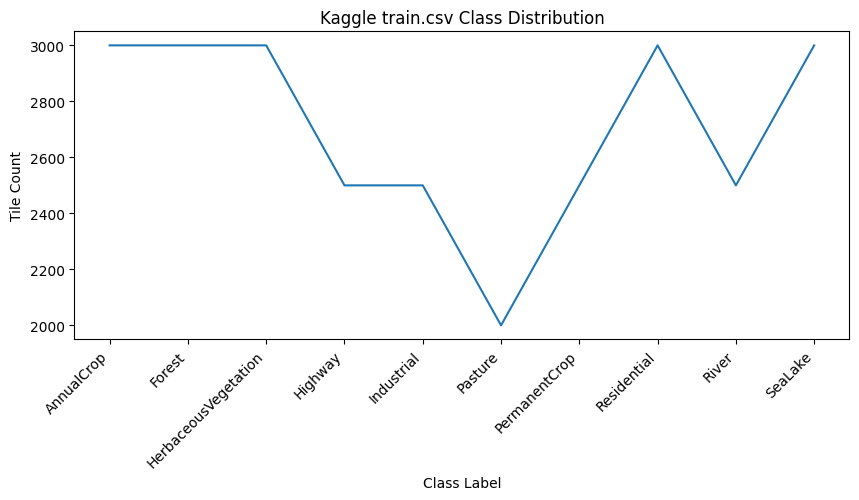

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(label_counts.index, label_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class Label')
plt.ylabel('Tile Count')
plt.title('Kaggle train.csv Class Distribution');

In [37]:
label_mean = np.mean(label_counts.values)
label_std = np.std(label_counts.values)
{
    'mean_tiles_per_class': label_mean,
    'std_tiles_per_class': label_std,
}

{'mean_tiles_per_class': np.float64(2700.0),
 'std_tiles_per_class': np.float64(331.66247903554)}

In [38]:
eda_checks = {
    'missing_values': kaggle_train_df.isna().sum().to_dict(),
    'duplicate_paths': int(kaggle_train_df['path'].duplicated().sum()),
}
eda_checks

{'missing_values': {'path': 0, 'label': 0}, 'duplicate_paths': 0}

### Kaggle test set – Exploratory Data Analysis

In [39]:

if 'EXTRACT_ROOT' not in globals():
    raise RuntimeError('Run the Kaggle extraction cell before this EDA block.')

TEST_CSV_PATH = TEST_CSV_PATH if 'TEST_CSV_PATH' in globals() else None
print(f"Using EXTRACT_ROOT for test set: {EXTRACT_ROOT}")


Using EXTRACT_ROOT for test set: /content/drive/MyDrive/ML_HSG/kaggle_data


In [40]:

test_search_patterns = [
    str(EXTRACT_ROOT / '**' / 'testset' / 'testset' / '*.npy'),
    str(EXTRACT_ROOT / '**' / 'testset' / '*.npy'),
    str(EXTRACT_ROOT / '**' / '*.npy'),
]

test_npy_paths = []
for pattern in test_search_patterns:
    hits = sorted(Path(p) for p in glob.glob(pattern, recursive=True))
    if hits:
        test_npy_paths = hits
        break

if not test_npy_paths:
    raise FileNotFoundError(f'No test .npy files found under {EXTRACT_ROOT}')

print(f"Kaggle test tiles detected: {len(test_npy_paths)}")
print(f"Sample test files: {[p.name for p in test_npy_paths[:5]]}")


Kaggle test tiles detected: 4232
Sample test files: ['test_0.npy', 'test_1.npy', 'test_10.npy', 'test_100.npy', 'test_1000.npy']


In [41]:

rng = np.random.default_rng(RANDOM_SEED)

train_cap = min(128, len(samples))
train_indices = rng.choice(len(samples), size=train_cap, replace=False) if train_cap else []
train_channel_counts = Counter()
train_min, train_max = float('inf'), float('-inf')
for idx in train_indices:
    arr = read_multispectral(samples[idx][0])
    train_channel_counts[arr.shape[0]] += 1
    train_min = min(train_min, float(arr.min()))
    train_max = max(train_max, float(arr.max()))

test_cap = min(256, len(test_npy_paths))
test_indices = rng.choice(len(test_npy_paths), size=test_cap, replace=False) if test_cap else []
test_channel_counts = Counter()
test_min, test_max = float('inf'), float('-inf')
for idx in test_indices:
    path = test_npy_paths[idx]
    arr = np.load(path, allow_pickle=False)
    arr = ensure_channel_first(arr, source=str(path))
    test_channel_counts[arr.shape[0]] += 1
    test_min = min(test_min, float(arr.min()))
    test_max = max(test_max, float(arr.max()))

comparison_df = pd.DataFrame(
    [
        {
            'split': 'train',
            'tiles_total': len(samples),
            'sampled_tiles': int(train_cap),
            'unique_labels': len(CLASS_NAMES),
            'value_min': float(train_min),
            'value_max': float(train_max),
        },
        {
            'split': 'test',
            'tiles_total': len(test_npy_paths),
            'sampled_tiles': int(test_cap),
            'unique_labels': np.nan,
            'value_min': float(test_min),
            'value_max': float(test_max),
        },
    ]
)
display(comparison_df)

{
    'train_channel_counts': dict(sorted(train_channel_counts.items())),
    'test_channel_counts': dict(sorted(test_channel_counts.items())),
}


,split,tiles_total,sampled_tiles,unique_labels,value_min,value_max
0,train,27000,128,10.0,1.0,16556.0
1,test,4232,256,NaN,1.0,16712.0


{'train_channel_counts': {13: 128}, 'test_channel_counts': {12: 256}}

## 5) Train / Validation / Test Split

In [42]:
# NOTE: Scene-aware grouping disabled per user request. Original logic retained below.
# paths = np.array([str(p) for p, _ in samples], dtype=object)
# labels = np.array([label for _, label in samples], dtype=np.int64)
# indices = np.arange(len(samples))
#
# META_SCENE_KEYS = (
#     "scene_id",
#     "tile_id",
#     "TILE_ID",
#     "PRODUCT_ID",
#     "DATATAKE_IDENTIFIER",
#     "GRANULE_ID",
#     "MGRS_TILE",
#     "SENSING_TIME",
# )
#
#
# @lru_cache(maxsize=None)
# def infer_scene_id(path_str: str) -> str:
#     path = Path(path_str)
#     try:
#         with rasterio.open(path) as src:
#             tags = src.tags()
#             for key in META_SCENE_KEYS:
#                 value = tags.get(key)
#                 if value:
#                     return f"{path.parent.name}_{value}"
#     except Exception:
#         pass
#
#     stem = path.stem
#     digits = ''.join(ch for ch in stem if ch.isdigit())
#     if digits:
#         return f"{path.parent.name}_{digits}"
#     parts = stem.split('_')
#     if len(parts) > 1:
#         base = '_'.join(parts[:-1])
#     else:
#         base = stem
#     return f"{path.parent.name}_{base}"
#
#
# def build_fold_assignments(paths, labels, groups, n_splits: int = 5):
#     sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
#     fold_ids = np.full(len(paths), -1, dtype=np.int64)
#     for fold_id, (_, val_idx) in enumerate(sgkf.split(paths, labels, groups)):
#         fold_ids[val_idx] = fold_id
#     if (fold_ids < 0).any():
#         raise RuntimeError("Some samples were not assigned to a fold."
#                            " Check group construction.")
#     return fold_ids
#
# scene_ids = np.array([infer_scene_id(p) for p in paths], dtype=object)
# print(f"Unique scene ids inferred: {len(np.unique(scene_ids))} (over {len(scene_ids)} samples)")
#
# try:
#     fold_assignments = build_fold_assignments(paths, labels, scene_ids, n_splits=5)
#     fold_counts = Counter(fold_assignments)
#     print("Fold sizes:", dict(sorted(fold_counts.items())))
#     ordered_folds = [fold for fold, _ in fold_counts.most_common()]
#     if len(ordered_folds) < 2:
#         raise ValueError("Need at least two folds for validation/testing.")
#     test_fold = ordered_folds[0]
#     val_fold = ordered_folds[1]
#     train_idx = np.where((fold_assignments != test_fold) & (fold_assignments != val_fold))[0]
#     val_idx = np.where(fold_assignments == val_fold)[0]
#     test_idx = np.where(fold_assignments == test_fold)[0]
# except Exception as exc:
#     print(f"StratifiedGroupKFold failed ({exc}). Falling back to GroupShuffleSplit without stratification.")
#     gss_test = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=RANDOM_SEED)
#     trainval_idx, test_idx = next(gss_test.split(paths, labels, scene_ids))
#     gss_val = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=RANDOM_SEED)
#     train_idx_rel, val_idx_rel = next(gss_val.split(paths[trainval_idx], labels[trainval_idx], scene_ids[trainval_idx]))
#     train_idx = trainval_idx[train_idx_rel]
#     val_idx = trainval_idx[val_idx_rel]
#
# train_samples = [samples[i] for i in train_idx]
# val_samples = [samples[i] for i in val_idx]
# test_samples = [samples[i] for i in test_idx]
#
#
# def describe_split(name: str, subset_idx: np.ndarray) -> None:
#     subset_labels = labels[subset_idx]
#     subset_groups = scene_ids[subset_idx]
#     total = len(subset_idx)
#     unique_groups = len(np.unique(subset_groups))
#     counts = Counter(subset_labels)
#     missing = sorted(set(range(len(CLASS_NAMES))) - set(counts.keys()))
#     missing_names = [IDX_TO_CLASS[idx] for idx in missing]
#     print(f"{name}: {total} samples | {unique_groups} unique scene ids")
#     head = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:3]
#     head_desc = ", ".join(f"{IDX_TO_CLASS[idx]}: {count} ({count / total:.1%})" for idx, count in head)
#     print(f"  Top classes -> {head_desc}")
#     if missing:
#         print(f"  Missing classes -> {missing_names}")
#     else:
#         print("  Missing classes -> None")
#
#
# def assert_class_coverage(name: str, subset_idx: np.ndarray) -> None:
#     subset_labels = set(labels[subset_idx])
#     missing = sorted(set(range(len(CLASS_NAMES))) - subset_labels)
#     if missing:
#         missing_names = ", ".join(IDX_TO_CLASS[idx] for idx in missing)
#         raise ValueError(f"{name} split is missing classes: {missing_names}")
#
#
# describe_split("Train", train_idx)
# describe_split("Val", val_idx)
# describe_split("Test", test_idx)
#
# assert_class_coverage("Train", train_idx)
# assert_class_coverage("Val", val_idx)
# assert_class_coverage("Test", test_idx)
#
# print(f"Train: {len(train_samples)} | Val: {len(val_samples)} | Test: {len(test_samples)}")
#

In [43]:
paths = np.array([str(p) for p, _ in samples], dtype=object)
labels = np.array([label for _, label in samples], dtype=np.int64)

train_idx = np.arange(len(samples), dtype=np.int64)
val_idx = np.array([], dtype=np.int64)

def summarize_indices(name: str, subset_idx: np.ndarray) -> None:
    subset_labels = labels[subset_idx]
    total = len(subset_idx)
    counts = Counter(subset_labels)
    top = counts.most_common(3)
    missing = sorted(set(range(len(CLASS_NAMES))) - set(counts.keys()))
    print(f"{name}: {total} samples")
    if top:
        desc = ", ".join(f"{IDX_TO_CLASS[idx]}: {count} ({count / total:.1%})" for idx, count in top)
        print(f"  Top classes -> {desc}")
    if missing:
        missing_names = [IDX_TO_CLASS[idx] for idx in missing]
        print(f"  Missing classes -> {missing_names}")
    else:
        print("  Missing classes -> None")

train_samples = list(samples)
val_samples = []

if 'test_npy_paths' not in globals():
    raise RuntimeError("Kaggle test .npy tiles not loaded; run the discovery cell first.")

test_samples = [p if isinstance(p, Path) else Path(p) for p in test_npy_paths]
print(f"Collected {len(test_samples)} Kaggle test tiles for inference.")

summarize_indices("Train", train_idx)
print("Validation split skipped per configuration; all training samples used for fine-tuning.")

print(f"Train: {len(train_samples)} | Val: {len(val_samples)} | Test: {len(test_samples)}")


Collected 4232 Kaggle test tiles for inference.
Train: 27000 samples
  Top classes -> AnnualCrop: 3000 (11.1%), Forest: 3000 (11.1%), HerbaceousVegetation: 3000 (11.1%)
  Missing classes -> None
Validation split skipped per configuration; all training samples used for fine-tuning.
Train: 27000 | Val: 0 | Test: 4232



### Data Exploration – EuroSAT splits
Understanding how many samples each split contains per class helps verify the stratification and spot imbalance we might want to address with weighted losses or sampling.


subset,train
class_name,
AnnualCrop,3000
Forest,3000
HerbaceousVegetation,3000
Highway,2500
Industrial,2500
Pasture,2000
PermanentCrop,2500
Residential,3000
River,2500


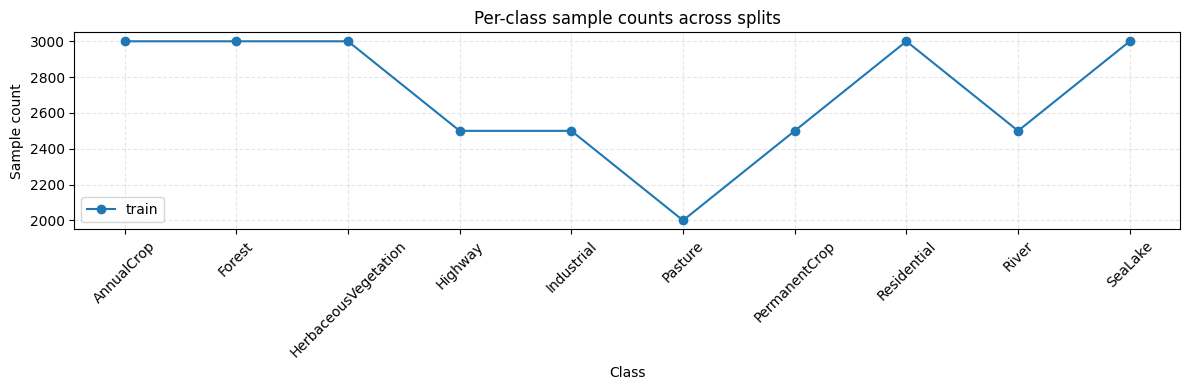

In [44]:
split_frames = []
for name, idx in (("train", train_idx), ("val", val_idx)):
    if idx.size == 0:
        continue
    subset_labels = labels[idx]
    frame = (
        pd.DataFrame({"subset": name, "label_idx": subset_labels})
        .assign(class_name=lambda df: df["label_idx"].map(IDX_TO_CLASS))
    )
    split_frames.append(frame)

if not split_frames:
    print('No additional splits beyond training to visualize.')
else:
    distribution_df = pd.concat(split_frames, ignore_index=True)
    counts = (
        distribution_df
        .groupby(["subset", "class_name"], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )

    display(counts.pivot(index="class_name", columns="subset", values="count").fillna(0).astype(int))

    fig, ax = plt.subplots(figsize=(12, 4))
    for subset_name, subset_df in counts.groupby("subset"):
        ax.plot(
            subset_df["class_name"],
            subset_df["count"],
            marker="o",
            label=subset_name,
        )
    ax.set_xlabel("Class")
    ax.set_ylabel("Sample count")
    ax.set_title("Per-class sample counts across splits")
    ax.tick_params(axis="x", rotation=45)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [45]:
train_paths_for_stats = [path for path, _ in train_samples]
band_stats = compute_band_percentiles(
    train_paths_for_stats,
    sample_per_image=1024,
    low=2.0,
    high=98.0,
    max_images=1500,
    seed=RANDOM_SEED,
)
update_global_band_stats(band_stats)

print(
    f"Computed global band stats from {band_stats['num_images']} training tiles "
    f"(sample_per_image={band_stats['sample_per_image']})."
)
for band_idx, (lo, hi) in enumerate(zip(band_stats["low"], band_stats["high"])):
    print(f"  Band {band_idx:02d}: low={lo:.2f}, high={hi:.2f}, range={hi - lo:.2f}")

example_arr = load_multispectral(train_samples[0][0])
print(
    f"Example normalized tile stats -> min={example_arr.min():.3f}, "
    f"max={example_arr.max():.3f}, mean={example_arr.mean():.3f}"
)


Computed global band stats from 1500 training tiles (sample_per_image=1024).
  Band 00: low=1064.00, high=1873.00, range=809.00
  Band 01: low=785.00, high=1915.00, range=1130.00
  Band 02: low=708.00, high=2119.00, range=1411.00
  Band 03: low=417.00, high=2947.00, range=2530.00
  Band 04: low=706.00, high=3208.00, range=2502.00
  Band 05: low=1480.00, high=4079.00, range=2599.00
  Band 06: low=1655.00, high=5042.00, range=3387.00
  Band 07: low=1565.00, high=4882.00, range=3317.00
  Band 08: low=408.00, high=1883.00, range=1475.00
  Band 09: low=8.00, high=21.00, range=13.00
  Band 10: low=1088.00, high=4489.00, range=3401.00
  Band 11: low=467.00, high=3346.00, range=2879.00
  Band 12: low=1824.00, high=5475.00, range=3651.00
Example normalized tile stats -> min=0.000, max=1.000, mean=0.351


## 6) Load Hugging Face EuroSatCNN

In [46]:

LOCAL_MODEL_DIR = Path('/content/drive/MyDrive/ML_HSG/models/Rhodham96-EuroSatCNN')
MODEL_DEF_PATH = LOCAL_MODEL_DIR / 'model_def.py'
WEIGHTS_PATH = LOCAL_MODEL_DIR / 'pytorch_model.bin'

HF_REPO_ID = 'Rhodham96/EuroSatCNN'
HF_CACHE_DIR = Path('/content/hf_cache')
HF_CACHE_DIR.mkdir(parents=True, exist_ok=True)

hf_token = os.getenv('HF_TOKEN')
hf_download_kwargs = {
    'repo_id': HF_REPO_ID,
    'cache_dir': str(HF_CACHE_DIR),
}
if hf_token:
    hf_download_kwargs['token'] = hf_token


def resolve_model_file(filename: str) -> Path:
    local_path = LOCAL_MODEL_DIR / filename
    if local_path.exists():
        return local_path
    return Path(hf_hub_download(filename=filename, **hf_download_kwargs))


def load_module_from_path(module_name: str, file_path: Path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module


model_def_path = resolve_model_file('model_def.py')
model_def_module = load_module_from_path('hf_eurosatcnn_def', model_def_path)
EuroSatCNN = getattr(model_def_module, 'EuroSatCNN', None)
if EuroSatCNN is None:
    EuroSatCNN = getattr(model_def_module, 'EuroSATCNN', None)
if EuroSatCNN is None:
    available = [name for name in dir(model_def_module) if not name.startswith('_')]
    raise AttributeError(f"EuroSatCNN class not found in model_def.py. Available objects: {available}")

weights_path = resolve_model_file('pytorch_model.bin')
state_dict = torch.load(weights_path, map_location='cpu')

model = EuroSatCNN(num_classes=len(CLASS_NAMES))
missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
if missing_keys:
    print(f"Warning: missing keys when loading pretrained weights -> {missing_keys}")
if unexpected_keys:
    print(f"Warning: unexpected keys when loading pretrained weights -> {unexpected_keys}")

model.to(DEVICE)


class EuroSatCNNProcessor:
    def __call__(self, images, return_tensors: str = 'pt'):
        arr = np.asarray(images, dtype=np.float32)
        if arr.ndim != 3:
            raise ValueError(f'Expected image with 3 dimensions (H, W, C); got shape={arr.shape}')
        if arr.max() > 1.5:
            arr = arr / 2750.0
        arr = np.clip(arr, 0.0, 1.0)
        tensor = torch.from_numpy(np.moveaxis(arr, -1, 0).copy()).float().contiguous()
        if return_tensors == 'pt':
            tensor = tensor.unsqueeze(0)
        return {'pixel_values': tensor}


processor = EuroSatCNNProcessor()
model.config = SimpleNamespace(
    id2label={idx: name for idx, name in enumerate(CLASS_NAMES)},
    label2id={name: idx for idx, name in enumerate(CLASS_NAMES)},
    num_labels=len(CLASS_NAMES),
)

print(f"Loaded EuroSatCNN weights from {weights_path}")


Loaded EuroSatCNN weights from /content/drive/MyDrive/ML_HSG/models/Rhodham96-EuroSatCNN/pytorch_model.bin


## 7) Dataset & DataLoaders with Augmentation

In [47]:
class EuroSATDataset(Dataset):
    def __init__(self, samples, processor, train: bool = False, augment: bool = False):
        self.samples = samples
        self.processor = processor
        self.train = train
        self.augment = augment

    def __len__(self) -> int:
        return len(self.samples)

    def random_augment(self, arr: np.ndarray) -> np.ndarray:
        if random.random() < 0.5:
            arr = np.flip(arr, axis=0).copy()
        if random.random() < 0.5:
            arr = np.flip(arr, axis=1).copy()
        if random.random() < 0.5:
            k = random.randint(1, 3)
            arr = np.rot90(arr, k=k, axes=(0, 1)).copy()
        if random.random() < 0.3:
            noise = np.random.normal(0.0, 0.02, size=arr.shape).astype(np.float32)
            arr = np.clip(arr + noise, 0.0, 1.0)
        return arr

    def __getitem__(self, idx: int):
        path, label = self.samples[idx]
        arr = load_multispectral(path, normalize=False)  # keep raw reflectance values
        arr = np.moveaxis(arr, 0, -1).astype(np.float32, copy=False)   # (H, W, C)
        if arr.max() > 1.5:  # scale raw reflectance to match EuroSATCNN training
            arr = np.clip(arr / 2750.0, 0.0, 1.0)
        if self.train and self.augment:
            arr = self.random_augment(arr)
        inputs = self.processor(images=arr, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)
        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(label, dtype=torch.long),
        }


In [48]:
BATCH_SIZE = 32
NUM_WORKERS = 0  # avoid multiprocessing issues in notebook/Colab environments

train_dataset = EuroSATDataset(train_samples, processor, train=True, augment=True)
val_dataset = EuroSATDataset(val_samples, processor, train=False, augment=False) if val_samples else None
test_dataset = None

if test_samples:
    first_sample = test_samples[0]
    if isinstance(first_sample, (tuple, list)) and len(first_sample) == 2:
        test_dataset = EuroSATDataset(test_samples, processor, train=False, augment=False)
    else:
        print("Kaggle test tiles detected (paths only). Labeled test loader skipped; use the inference section below.")

def make_loader(ds, shuffle: bool = False):
    return DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

train_loader = make_loader(train_dataset, shuffle=True)
val_loader = make_loader(val_dataset) if val_dataset is not None and len(val_dataset) > 0 else None
test_loader = make_loader(test_dataset) if test_dataset is not None and len(test_dataset) > 0 else None

val_batches = len(val_loader) if val_loader is not None else 0
test_batches = len(test_loader) if test_loader is not None else 0
print(f"Batches -> train: {len(train_loader)} | val: {val_batches} | test: {test_batches}")


Kaggle test tiles detected (paths only). Labeled test loader skipped; use the inference section below.
Batches -> train: 844 | val: 0 | test: 0


## 8) Optimiser, Regularisation & Training Loop

In [ ]:
EPOCHS = 15
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.05
GRAD_CLIP = 1.0
PATIENCE = 4
USE_AMP = torch.cuda.is_available()

steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCHS
warmup_steps = max(10, int(0.1 * total_steps))

criterion_train = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
criterion_eval = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

try:
    scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP)
except TypeError:
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

_AUTOCAST_KWARGS = {}
if hasattr(torch, "amp") and hasattr(torch.amp, "autocast"):
    try:
        _ = torch.amp.autocast(device_type="cuda", enabled=False)
        autocast_cm = torch.amp.autocast
        _AUTOCAST_KWARGS = {"device_type": "cuda"}
    except TypeError:
        autocast_cm = torch.cuda.amp.autocast
else:
    autocast_cm = torch.cuda.amp.autocast

def get_model_logits(model, pixel_values):
    try:
        outputs = model(pixel_values=pixel_values)
    except TypeError:
        outputs = model(pixel_values)
    if isinstance(outputs, torch.Tensor):
        return outputs
    if isinstance(outputs, dict):
        if "logits" in outputs:
            return outputs["logits"]
        raise KeyError("Model output dict missing 'logits'")
    if hasattr(outputs, "logits"):
        return outputs.logits
    raise AttributeError("Model output does not include logits")

def evaluate(model, loader, criterion=None):
    model.eval()
    loss_sum = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            pixel_values = batch["pixel_values"].to(DEVICE, non_blocking=True)
            labels = batch["labels"].to(DEVICE, non_blocking=True)
            logits = get_model_logits(model, pixel_values)
            if criterion is not None:
                loss = criterion(logits, labels)
                loss_sum += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    avg_loss = (loss_sum / total) if (criterion is not None and total > 0) else float('nan')
    acc = correct / total if total else 0.0
    all_labels = torch.cat(all_labels).numpy() if all_labels else np.array([])
    all_preds = torch.cat(all_preds).numpy() if all_preds else np.array([])
    return {"loss": avg_loss, "acc": acc, "labels": all_labels, "preds": all_preds}

history = []
best_state = None
best_val_acc = 0.0
best_epoch = -1
patience_counter = 0
has_val_loader = val_loader is not None

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False)
    for batch in progress:
        pixel_values = batch["pixel_values"].to(DEVICE, non_blocking=True)
        labels = batch["labels"].to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast_cm(enabled=USE_AMP, **_AUTOCAST_KWARGS):
            logits = get_model_logits(model, pixel_values)
            loss = criterion_train(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        preds = logits.detach().argmax(dim=1)
        epoch_loss += loss.item() * labels.size(0)
        epoch_correct += (preds == labels).sum().item()
        epoch_total += labels.size(0)

        progress.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{(preds == labels).float().mean().item():.3f}"
        })

    train_loss = epoch_loss / epoch_total
    train_acc = epoch_correct / epoch_total

    if has_val_loader:
        val_metrics = evaluate(model, val_loader, criterion_eval)
        val_loss = val_metrics["loss"]
        val_acc = val_metrics["acc"]
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

        print(f"Epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            print(f"--> New best model (val_acc={best_val_acc:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break
    else:
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": float('nan'),
            "val_acc": float('nan')
        })
        print(f"Epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f}")

if has_val_loader and best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, "eurosatcnn_best.pt")
    print(f"Restored best model from epoch {best_epoch} (val_acc={best_val_acc:.4f})")
elif not has_val_loader:
    torch.save(model.state_dict(), "eurosatcnn_final.pt")
    print("Saved final model weights to eurosatcnn_final.pt")
else:
    print("Warning: best_state is None – training may have failed.")


Epoch 1/15 [train]:   0%|          | 0/844 [00:00<?, ?it/s]

In [ ]:
history_df = pd.DataFrame(history)
if history_df.empty:
    print("Training history is empty; no plots to display.")
else:
    display(history_df)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history_df['epoch'], history_df['train_loss'], label='Train', marker='o')
    if history_df['val_loss'].notna().any():
        axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Validation', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss per Epoch')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.3)

    axes[1].plot(history_df['epoch'], history_df['train_acc'], label='Train', marker='o')
    if history_df['val_acc'].notna().any():
        axes[1].plot(history_df['epoch'], history_df['val_acc'], label='Validation', marker='o')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy per Epoch')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    if history_df['val_acc'].notna().any():
        best_idx = history_df['val_acc'].idxmax()
        best_row = history_df.loc[best_idx]
        print(f"Best validation accuracy: {best_row['val_acc']:.4f} at epoch {int(best_row['epoch'])}")
    else:
        best_idx = history_df['train_acc'].idxmax()
        best_row = history_df.loc[best_idx]
        print(f"Best training accuracy: {best_row['train_acc']:.4f} at epoch {int(best_row['epoch'])}")


## 9) Evaluate on Held-out Test Set

In [ ]:
if test_loader is None:
    print('No labeled test set available; skipping evaluation.')
else:
    test_metrics = evaluate(model, test_loader, criterion_eval)
    print(f"Test accuracy: {test_metrics['acc']:.4f}")

    report_dict = classification_report(
        test_metrics['labels'],
        test_metrics['preds'],
        target_names=CLASS_NAMES,
        digits=4,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    report_df.index.name = 'class'
    report_df.reset_index(inplace=True)
    display(report_df)

    cm = confusion_matrix(test_metrics['labels'], test_metrics['preds'])
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES,
        ax=ax
    )
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.show()

    per_class_df = (
        pd.DataFrame({
            'label': test_metrics['labels'],
            'pred': test_metrics['preds']
        })
        .assign(correct=lambda df: (df['label'] == df['pred']).astype(float))
        .groupby('label')['correct']
        .mean()
        .mul(100)
        .rename('accuracy')
        .reset_index()
    )
    per_class_df['class'] = per_class_df['label'].map(IDX_TO_CLASS)
    per_class_df = per_class_df.sort_values('accuracy', ascending=False)

    fig, ax = plt.subplots(figsize=(10, 4))
    positions = np.arange(len(per_class_df))
    ax.bar(positions, per_class_df['accuracy'], color='steelblue')
    ax.set_xticks(positions)
    ax.set_xticklabels(per_class_df['class'], rotation=45, ha='right')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Per-class Accuracy (Test Set)')
    ax.set_ylim(0, 100)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


## 10) Kaggle Inference & Submission

In [ ]:

# Mount (again) in case the session was reset before inference
drive.mount('/content/drive', force_remount=True)

if 'EXTRACT_ROOT' not in globals() or 'KAGGLE_ROOT' not in globals():
    raise RuntimeError('Extraction globals missing. Run the setup cell at the top first.')

search_patterns = [
    str(EXTRACT_ROOT / '**' / 'testset' / 'testset' / '*.npy'),
    str(EXTRACT_ROOT / '**' / 'testset' / '*.npy'),
    str(EXTRACT_ROOT / '**' / '*.npy'),
]

npy_paths = []
for pattern in search_patterns:
    hits = sorted(Path(p) for p in glob.glob(pattern, recursive=True))
    if hits:
        npy_paths = hits
        break

if len(npy_paths) == 0:
    raise FileNotFoundError(f'No .npy files found in Kaggle archive under {EXTRACT_ROOT}')

print(f"Found {len(npy_paths)} inference tiles. Example: {npy_paths[:3]}")

def summarize_kaggle_tiles(paths, max_files: int = None):
    channel_counter = Counter()
    global_min = float('inf')
    global_max = float('-inf')
    examined = 0
    for path in paths if max_files is None else paths[:max_files]:
        arr = np.load(path, allow_pickle=False)
        arr = ensure_channel_first(arr, source=str(path))
        channel_counter[arr.shape[0]] += 1
        global_min = min(global_min, float(arr.min()))
        global_max = max(global_max, float(arr.max()))
        examined += 1
    print(f"Kaggle tiles examined: {examined}")
    print('Channel-count distribution:', dict(sorted(channel_counter.items())))
    print(f"Global value range across examined tiles: [{global_min:.4f}, {global_max:.4f}]")

summarize_kaggle_tiles(npy_paths)

def extract_id(stem: str) -> int:
    match = re.search(r'(\d+)$', stem)
    if match:
        return int(match.group(1))
    digits = ''.join(ch for ch in stem if ch.isdigit())
    return int(digits) if digits else -1


class EuroSATNPYDataset(Dataset):
    def __init__(self, paths, processor, check_preview: bool = True):
        self.paths = paths
        self.processor = processor
        self.check_preview = check_preview
        if self.check_preview and len(self.paths) > 0:
            self._preview_statistics()

    def _preview_statistics(self, num_examples: int = 3):
        mins = []
        maxs = []
        channel_counts = []
        for path in self.paths[:num_examples]:
            arr = np.load(path, allow_pickle=False)
            arr = ensure_channel_first(arr, source=str(path))
            channel_counts.append(arr.shape[0])
            mins.append(float(arr.min()))
            maxs.append(float(arr.max()))
        print(
            'Kaggle tile preview -> '
            f"channels={sorted(set(channel_counts))} | "
            f"value range~[{min(mins):.3f}, {max(maxs):.3f}]"
        )
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        arr = np.load(path, allow_pickle=False)
        arr = ensure_channel_first(arr, source=str(path))
        arr = pad_to_13_bands(arr)
        arr = np.moveaxis(arr, 0, -1).astype(np.float32, copy=False)
        if arr.max() > 1.5:
            arr = np.clip(arr / 2750.0, 0.0, 1.0)
        if self.processor is not None:
            inputs = self.processor(images=arr, return_tensors='pt')
            pixel_values = inputs['pixel_values'].squeeze(0)
        else:
            chw = np.moveaxis(arr, -1, 0)
            pixel_values = torch.from_numpy(chw.copy()).float()
        sample_id = extract_id(path.stem)
        return {'pixel_values': pixel_values, 'id': sample_id}


kaggle_dataset = EuroSATNPYDataset(npy_paths, processor)
kaggle_loader = DataLoader(kaggle_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

model.eval()
pred_ids = []
pred_indices = []

with torch.no_grad():
    for batch in tqdm(kaggle_loader, desc='Kaggle inference'):
        pixel_values = batch['pixel_values'].to(DEVICE, non_blocking=True)
        logits = get_model_logits(model, pixel_values)
        preds = logits.argmax(dim=1).cpu().tolist()
        pred_indices.extend(preds)
        if isinstance(batch['id'], torch.Tensor):
            pred_ids.extend(batch['id'].cpu().tolist())
        else:
            pred_ids.extend(batch['id'])

pred_labels = [IDX_TO_CLASS[idx] for idx in pred_indices]
submission = pd.DataFrame({'test_id': pred_ids, 'label': pred_labels})
submission = submission.sort_values('test_id').reset_index(drop=True)

timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
submission_filename = f'submission_{timestamp}.csv'
submission_path = Path('/content') / submission_filename
submission.to_csv(submission_path, index=False)
print(f'Saved submission to {submission_path}')
print(submission.head())

output_dir = Path('/content/drive/MyDrive/ML_HSG/kaggle_submissions')
output_dir.mkdir(parents=True, exist_ok=True)
drive_path = output_dir / submission_filename
shutil.copy(submission_path, drive_path)
print(f'Copied submission to {drive_path}')

